In [2]:
# Setting up the Kaggle directory to download the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Creating a directory for the dataset and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [4]:
# Downloading the dataset from Kaggle and returning to the previous directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 690M/691M [00:33<00:00, 26.7MB/s]
100% 691M/691M [00:33<00:00, 21.8MB/s]
/content


In [5]:
# Unzipping the downloaded file, removing unusable file, and unpacking the data
!unzip -q dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv /content/dog_dataset

rm: cannot remove '/content/dog_dataset': Is a directory


# Data Loading and Preprocessing


In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [7]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
labels_all["id"] = labels_all["id"].apply(lambda x: x + ".jpg")

# Visualizing the Distribution of Dog Breeds

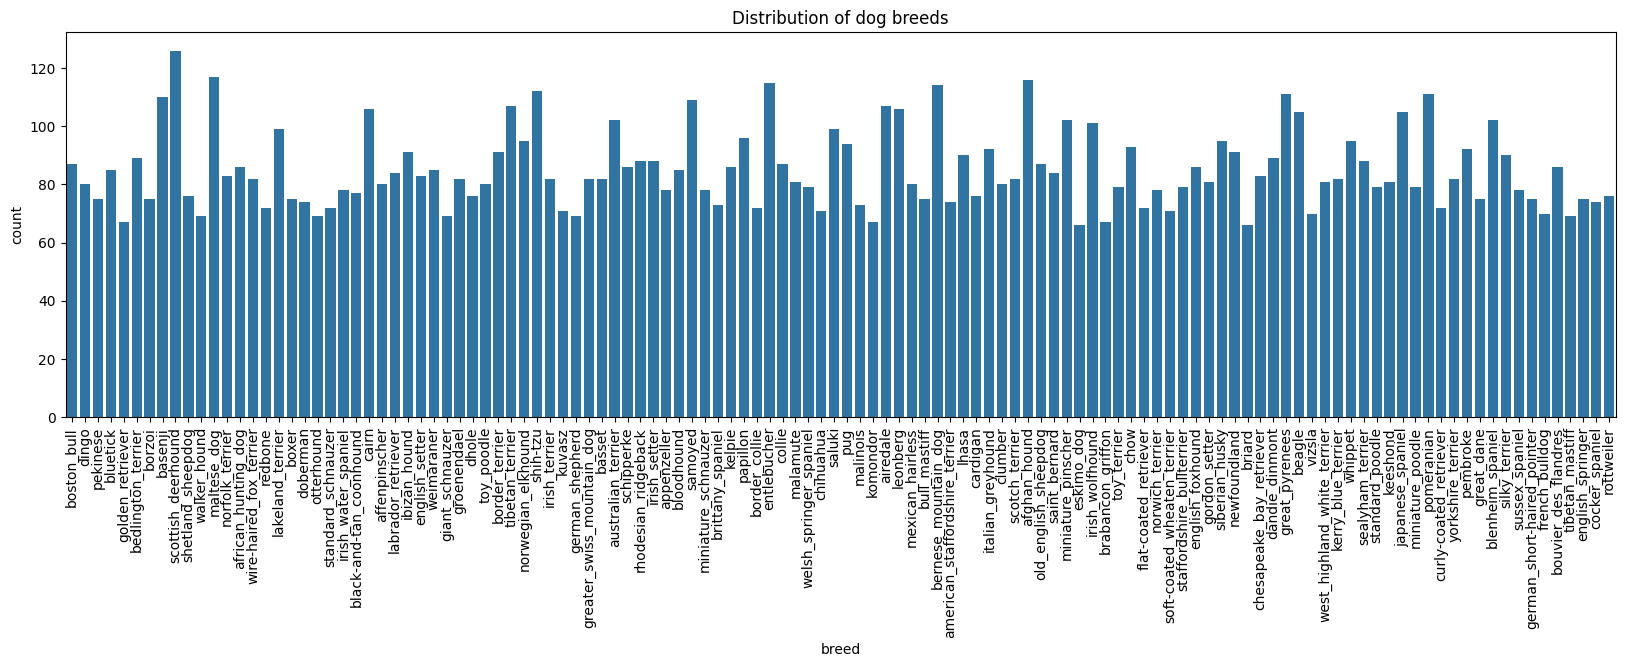

In [10]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.countplot(data=labels_all, x='breed')
plt.title('Distribution of dog breeds')
plt.show()

# Loading and Preparing Data


*   Training set which the model learns from.
*   Validation set which is used during training to evaluate the model’s performance and tune the hyperparameters.
*   Testing set which is used after training to evaluate how well our model has learned and how well it generalizes to unseen data.





In [8]:
RANDOM_STATE = 42
train_df, test_df = train_test_split(labels_all, test_size=0.1, random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)

## Visualizing Dog Breeds

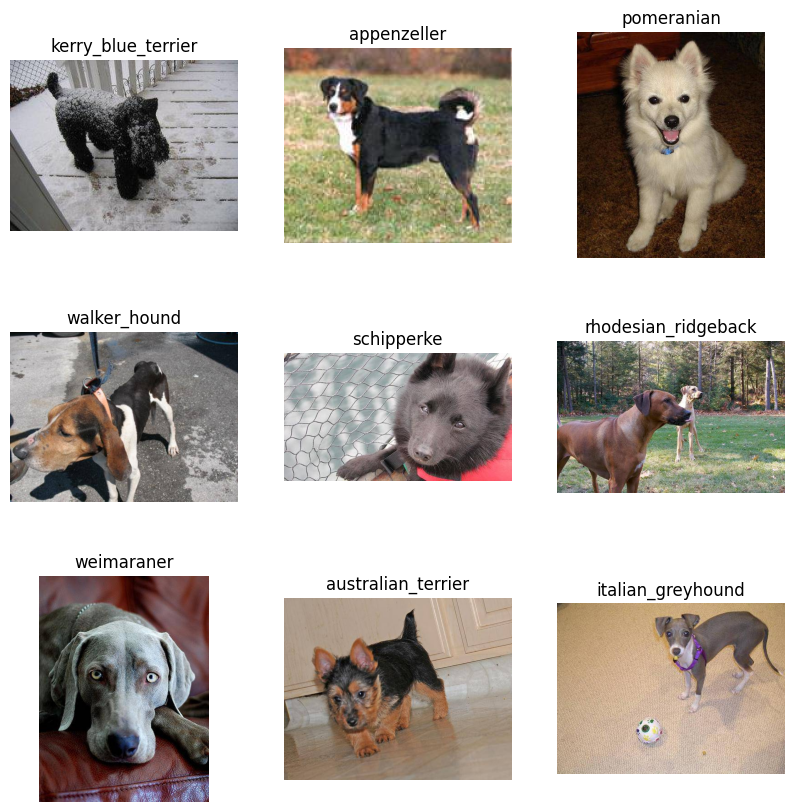

In [12]:
sample_images = train_df.sample(n=9)
plt.figure(figsize=(10,10))

for ind, image_id in enumerate(sample_images['id']):
    img = cv2.imread(f'dog_dataset/train/{image_id}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, ind+1)
    plt.imshow(img)
    plt.title(sample_images.iloc[ind]['breed'])
    plt.axis('off')

plt.show()

## Analyzing Image Sizes

In [13]:
image_sizes = [Image.open(f'dog_dataset/train/{img_id}').size for img_id in train_df['id']]

# Print some stats about image sizes
print(f'Min width: {min(sz[0] for sz in image_sizes)}')
print(f'Max width: {max(sz[0] for sz in image_sizes)}')
print(f'Min height: {min(sz[1] for sz in image_sizes)}')
print(f'Max height: {max(sz[1] for sz in image_sizes)}')

Min width: 97
Max width: 3264
Min height: 103
Max height: 2562


## Setting Up Constants

In [13]:
SIZE = (350,350)
BATCH_SIZE = 32
NUM_CLASSES = len(labels_all['breed'].unique())
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.7
EPOCHS = 5

## Preparing Data Generators

In [11]:
# Image processing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Data generators
train_generator = train_datagen.flow_from_dataframe(train_df, 'dog_dataset/train', 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(test_df, 'dog_dataset/train', 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_dataframe(val_df, 'dog_dataset/train', 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 7359 validated image filenames belonging to 120 classes.
Found 1023 validated image filenames belonging to 120 classes.
Found 1840 validated image filenames belonging to 120 classes.


# Building and Training the Model

In [19]:
# Base model
input_tensor = Input(shape=(SIZE[0], SIZE[1], 3))
base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False

83683744/83683744 [==============================] - 2s 0us/step


In [20]:
# Output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile model
model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [22]:
# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples//BATCH_SIZE,
                    validation_steps=val_generator.samples//BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
229/229 [==============================] - ETA: 0s - loss: 1.9647 - accuracy: 0.6623
Epoch 1: val_loss improved from inf to 0.62683, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 65s 249ms/step - loss: 1.9647 - accuracy: 0.6623 - val_loss: 0.6268 - val_accuracy: 0.8958
Epoch 2/5
229/229 [==============================] - ETA: 0s - loss: 0.5087 - accuracy: 0.8899
Epoch 2: val_loss improved from 0.62683 to 0.40782, saving model to model.h5
229/229 [==============================] - 55s 242ms/step - loss: 0.5087 - accuracy: 0.8899 - val_loss: 0.4078 - val_accuracy: 0.9052
Epoch 3/5
229/229 [==============================] - ETA: 0s - loss: 0.3686 - accuracy: 0.9065
Epoch 3: val_loss improved from 0.40782 to 0.34641, saving model to model.h5
229/229 [==============================] - 55s 240ms/step - loss: 0.3686 - accuracy: 0.9065 - val_loss: 0.3464 - val_accuracy: 0.9046
Epoch 4/5
229/229 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.9176
Epoch 4: val_loss improved from 0.34641 to 0.32528, saving model to model.h5
229/229 [==============================] - 54s 236ms/step - loss: 0.3005 - accurac

## Model Training Results
Over the course of 5 epochs, our model achieved an average training accuracy of approximately 92% and an average training loss of approximately 0.26. This represents a high degree of accuracy and a relatively low loss, suggesting that our model was able to learn from the training data effectively.

# Model Evaluation on Test Data

In [23]:
# Evaluate model on test data
score = model.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

32/32 [==============================] - 6s 192ms/step - loss: 0.2833 - accuracy: 0.9208
Test loss: 0.28333330154418945
Test accuracy: 0.9208211302757263


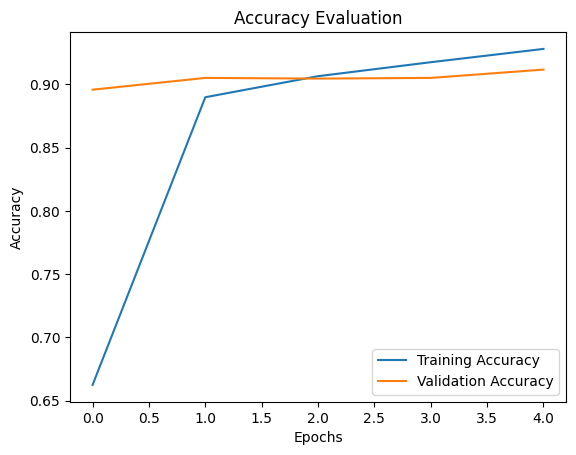

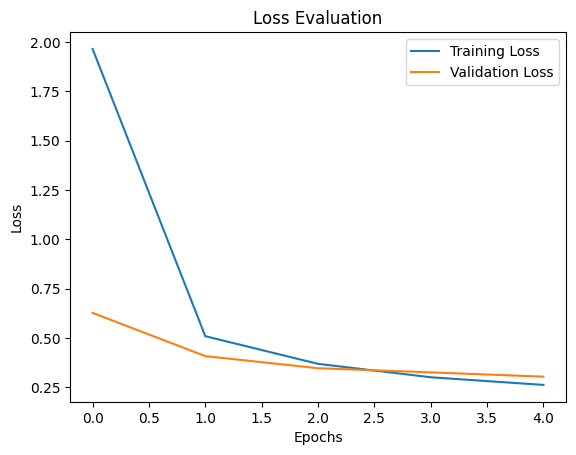

In [24]:
# Plotting Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# save model
model.save('final_model.h5')

In [9]:
# load model
model_loaded = load_model('final_model.h5')

In [16]:
score = model_loaded.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

32/32 [==============================] - 6s 196ms/step - loss: 0.2833 - accuracy: 0.9208
Test loss: 0.28333327174186707
Test accuracy: 0.9208211302757263


In [17]:
img = 'https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'

In [21]:
import requests
from io import BytesIO
img_url = 'https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'

# Fetch the image data from the URL
response = requests.get(img_url)
image_bytes = BytesIO(response.content)

# Convert the image file to an OpenCV image
file_bytes = np.asarray(bytearray(image_bytes.read()), dtype=np.uint8)
opencv_image = cv2.imdecode(file_bytes, 1)

In [22]:
# Resize the image to match model's input shape
opencv_image = cv2.resize(opencv_image, (350,350))  # resizing to (350,350)

In [23]:
# Prepare image for model prediction
opencv_image = opencv_image / 255.0  # rescaling
opencv_image = np.expand_dims(opencv_image, axis=0)

In [25]:
Y_pred = model_loaded.predict(opencv_image)

1/1 [==============================] - 2s 2s/step


In [26]:
# Defining class names
CLASS_NAMES = ['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz', 'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke', 'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malamute', 'welsh_springer_spaniel', 'chihuahua', 'saluki', 'pug', 'malinois', 'komondor', 'airedale', 'leonberg', 'mexican_hairless', 'bull_mastiff', 'bernese_mountain_dog', 'american_staffordshire_terrier', 'lhasa', 'cardigan', 'italian_greyhound', 'clumber', 'scotch_terrier', 'afghan_hound', 'old_english_sheepdog', 'saint_bernard', 'miniature_pinscher', 'eskimo_dog', 'irish_wolfhound', 'brabancon_griffon', 'toy_terrier', 'chow', 'flat-coated_retriever', 'norwich_terrier', 'soft-coated_wheaten_terrier', 'staffordshire_bullterrier', 'english_foxhound', 'gordon_setter', 'siberian_husky', 'newfoundland', 'briard', 'chesapeake_bay_retriever', 'dandie_dinmont', 'great_pyrenees', 'beagle', 'vizsla', 'west_highland_white_terrier', 'kerry_blue_terrier', 'whippet', 'sealyham_terrier', 'standard_poodle', 'keeshond', 'japanese_spaniel', 'miniature_poodle', 'pomeranian', 'curly-coated_retriever', 'yorkshire_terrier', 'pembroke', 'great_dane', 'blenheim_spaniel', 'silky_terrier', 'sussex_spaniel', 'german_short-haired_pointer', 'french_bulldog', 'bouvier_des_flandres', 'tibetan_mastiff', 'english_springer', 'cocker_spaniel', 'rottweiler']


In [27]:
# Display the predicted dog breed
print(f"The dog breed is most likely a {CLASS_NAMES[np.argmax(Y_pred)].replace('_', ' ').title()}.")

The dog breed is most likely a Soft-Coated Wheaten Terrier.
